# BERTopic_v1
---

## 1. Preprocessing
---

During the preprocessing we prepare the corpus' documents for further processing. Usually, this is done with a task in mind. As we are using the corpus to generate BERTopics the preprocessing is relatively minimal. This is because of the internal architecture of BERTopic, which can handle relatively much noise compared to other models and also needs sentences to be unchanged as the model works with embeddings. It is therefore good to bear in mind that other topic modeling techniques may therefore require more preprocessing. 

We start with importing the necessary libraries, needed for preprocessing the data:

In [5]:
from glob import glob # to read the collected data
from nltk.tokenize import sent_tokenize, word_tokenize # to split up sentences and do a total word count per paragraph
import re # to preprocess text

Next, I am defining some basic preprocessing functions to clean out document noise. Defining such functions is best done with documents in mind. It is therefore advisable to check some of the documents and see what kind of special signs or noise may be unique to the dataset. 

After defining the functions, we run them on the corpus in order to clean the noise and add the cleaned text to our training data:

In [6]:
def remove_urls(text, replacement_text=""):
    # Define a regex pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+') 
    # Use the sub() method to replace URLs with the specified replacement text
    text_without_urls = url_pattern.sub(replacement_text, text)
    return text_without_urls

def remove_extras(text, replacement_text=" "): 
    # Define a regex pattern to match extras and numbers
    url_pattern = re.compile(r'\x0c||[0-9]+|\x0f|\x12|\n|《 |》|※|( )|\x16|\x01|\x13|\x11|\x18') 
    # Use the sub() method to replace extras with the specified replacement text
    text_without_extras = url_pattern.sub(replacement_text, text)
    return text_without_extras

training_data = []

for file in glob("corpus/corpus_txt" + '/*.txt'):
    #filename = file.split('/')[1]
    with open(file, 'r') as f:
        text = f.read()
        text = remove_urls(text)
        text = remove_extras(text)
        training_data.append(text)

Since the documents are quite long, the [BERTopic documentation suggests](https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html) it is best pratice to split the documents into their sentences. There are different ways of doing so. After experimenting a little bit with the structures of the documents, the most reliable result is to split the documents into sentences and use consecutive sentences in the document to form paragraphs. 

We start with splitting the sentences in the documents. The NLTK library has a sentence tokenizer for this.

After this, we take each 3 consecutive sentences to add them together into a paragraph. The paragraphs will then be passed to the topic model for training, in this context they will be regarded as 'documents'.

In [7]:
# Creating a nested list of all sentences per document
sentences = [sent_tokenize(doc) for doc in training_data] 

# Defining a function to join three consecutive sentences into one string
def create_paragraphs (sentences, amount_sent = 3):
    paragraphs = []
   
    # Iterate over the sentences in steps of `amount_sent`
    for i in range(0, len(sentences), amount_sent):
        # Extract the next `amount_sent` sentences
        paragraph = sentences[i:i + amount_sent]
        paragraph = ' '.join(paragraph)
        # Add the bundle to the list of bundles
        paragraphs.append(paragraph)
     
    return paragraphs

paragraphs_all_docs = []

# Lastly let's run the function on each of the documents in the sentences (our nested list)
for doc in sentences:
    paragraphs_all_docs.append(create_paragraphs(doc))

# Our `paragraphs_all_docs` is still nested, however we cannot pass a nested list to the model
# In this final step we discard the document level of the paragraphs and add all the paragraphs into one list to pass to the model

paragraphs_all = [] # This will be our document variable

for doc in paragraphs_all_docs:
    for paragraph in doc:
        paragraphs_all.append(paragraph)

Let's check how many parapgraphs we have collected now:

In [8]:
len(paragraphs_all)

23632

It seems that we successfully chopped the corpus into smaller 3-sentence chunks, which enables the generation of topic models below.

Next, it is important that we check how many tokens are in a paragraph on average. This is because embeddings models such as the BERTopic default `sentence-transformers/all-MiniLM-L6-v2` may have specified lengths of tokens after which a document is truncated. This is because sentence transformers usually deal only with sentences or short paragraphs as the name suggestes and are not created to make embeddings on a document level. The `sentence-transformers/all-MiniLM-L6-v2` by default [truncates input text longer than 256 word pieces](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2). Therefore, it is important to ensure during preprocessing that the generated parapgraphs do not exceed this limit.

In [91]:
words_per_sent = [word_tokenize(t) for t in paragraphs_all] 

lengths = []
for paragraph in words_per_sent:
    lengths.append(len(paragraph))

print('Average length of a paragraph with 3 sentences:',sum(lengths)/len(lengths))

Average length of a paragraph with 3 sentences: 76.09186696005416


Lastly, in order to easily reload, we can save all the paragraphs to one text file and separate each paragraph with a linebreak:

In [12]:
filepath = 'corpus/paragraphs-all'

out = open(filepath, "w")
for para in paragraphs_all:
    out.write(para)
    out.write('\n')
out.close()

Now we should be able to load all the preprocessed text easily with the code chunk below:

In [18]:
filepath = 'corpus/paragraphs-all'

with open(filepath, "r") as out:
    paragraphs = out.read()
    paragraphs_all = paragraphs.split('\n')

## 2. Model creation
---

First, BERTopic will be used in a standard configuration to see how the results of the model are, with minimal fine-tuning.

Importing the necessary libraries:

In [14]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

In [24]:
#this ensures we clean the text of stopwords after the embeddings are done
umap_model = UMAP(n_neighbors=30, n_components=5, min_dist=0.1, metric='cosine', random_state=42)

vectorizer_model = CountVectorizer(stop_words="english") 

topic_model = BERTopic(verbose=True, vectorizer_model=vectorizer_model)

topics, probs = topic_model.fit_transform(paragraphs_all)

2024-06-13 13:10:11,732 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/739 [00:00<?, ?it/s]

2024-06-13 13:12:27,953 - BERTopic - Embedding - Completed ✓
2024-06-13 13:12:27,954 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-13 13:12:33,943 - BERTopic - Dimensionality - Completed ✓
2024-06-13 13:12:33,944 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

In [25]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1   8129                 -1_ai_data_systems_development   
1        0    595                0_personal_processing_gdpr_data   
2        1    423                                          1____   
3        2    374  2_regulators_respondents_regulatory_regulator   
4        3    348             3_act_la_commissioner_organization   
..     ...    ...                                            ...   
301    300     10                 300_entry_force_article_months   
302    301     10        301_component_machine_learning_software   
303    302     10               302_rd_federal_restricted_sought   
304    303     10             303_risk_mba_genderbased_airelated   
305    304     10                              304_art_ch_ss_par   

                                        Representation  \
0    [ai, data, systems, development, learning, dig...   
1    [personal, processing, gdpr, data, controller,...   
2                                 [, , , , , , , , , ]   
3    [regulators, respondents, regulatory, regulato...   
4    [act, la, commissioner, organization, loi, sur...   
..                                                 ...   
301  [entry, force, article, months, parliament, sh...   
302  [component, machine, learning, software, grasp...   
303  [rd, federal, restricted, sought, testing, acc...   
304  [risk, mba, genderbased, airelated, best, plus...   
305  [art, ch, ss, par, tsotsos, zemel, elephant, s...   

                                   Representative_Docs  
0    [( ) General-purpose AI models could pose syst...  
1    [of the GDPR as the person who determines the ...  
2                                [. . ., . . ., . . .]  
3    [Around a third of respondents argued that add...  
4    [Contrôle d’application : demande de l’institu...  
..                                                 ...  
301  [By … [four years from the date of entry into ...  
302  [Although a training software component is not...  
303  [What types of AI R&D and testing would  be ac...  
304  [Many used existing best practice processes an...  
305  [, al. ( )b) et d);  , ch. , art., ;  , ch. , ...  

[306 rows x 5 columns]

As the last step of this process, I will save this model to reproduce the result later and compare different optimizations of Topic Models. The model is saved using PyTorch.

In [27]:
# Saving the model using Pickle
topic_model.save("BERTopic_v1", serialization="pickle")

#embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
#topic_model.save("BERTopic_v1 ", serialization="pytorch", save_ctfidf=True, save_embedding_model=embedding_model)

2024-06-13 13:15:48,290 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



Now we can load the model anew anytime we want to explore the the topic model again:

In [22]:
# Load model
from bertopic import BERTopic
loaded_model = BERTopic.load("BERTopic_v1")

In [2]:
loaded_model.get_topic_info()

Topic  Count                                           Name  \
0       -1   8129                 -1_ai_data_systems_development   
1        0    595                0_personal_processing_gdpr_data   
2        1    423                                          1____   
3        2    374  2_regulators_respondents_regulatory_regulator   
4        3    348             3_act_la_commissioner_organization   
..     ...    ...                                            ...   
301    300     10                 300_entry_force_article_months   
302    301     10        301_component_machine_learning_software   
303    302     10               302_rd_federal_restricted_sought   
304    303     10             303_risk_mba_genderbased_airelated   
305    304     10                              304_art_ch_ss_par   

                                        Representation  \
0    [ai, data, systems, development, learning, dig...   
1    [personal, processing, gdpr, data, controller,...   
2                                 [, , , , , , , , , ]   
3    [regulators, respondents, regulatory, regulato...   
4    [act, la, commissioner, organization, loi, sur...   
..                                                 ...   
301  [entry, force, article, months, parliament, sh...   
302  [component, machine, learning, software, grasp...   
303  [rd, federal, restricted, sought, testing, acc...   
304  [risk, mba, genderbased, airelated, best, plus...   
305  [art, ch, ss, par, tsotsos, zemel, elephant, s...   

                                   Representative_Docs  
0    [( ) General-purpose AI models could pose syst...  
1    [of the GDPR as the person who determines the ...  
2                                [. . ., . . ., . . .]  
3    [Around a third of respondents argued that add...  
4    [Contrôle d’application : demande de l’institu...  
..                                                 ...  
301  [By … [four years from the date of entry into ...  
302  [Although a training software component is not...  
303  [What types of AI R&D and testing would  be ac...  
304  [Many used existing best practice processes an...  
305  [, al. ( )b) et d);  , ch. , art., ;  , ch. , ...  

[306 rows x 5 columns]

## 3. Model coherence
---

Topic models are evaluated accross different dimensions. One of them is coherence. 
To compare results and optimize topic models accordingly, we will check the coherence score of each model:

In [30]:
cv = loaded_model.vectorizer_model
X = cv.fit_transform(paragraphs_all)
doc_tokens = [text.split(" ") for text in paragraphs_all]

import gensim.corpora as corpora
id2word = corpora.Dictionary(doc_tokens)
texts = doc_tokens
corpus = [id2word.doc2bow(text) for text in texts]

topic_words = []
for i in range(len(loaded_model.get_topic_freq())-1):
  interim = []
  interim = [t[0] for t in loaded_model.get_topic(i)]
  topic_words.append(interim)

from gensim.models.coherencemodel import CoherenceModel

coherence_model = CoherenceModel(topics=topic_words, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_v')

print("Coherence score:", coherence_model.get_coherence())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Coherence score: 0.4610811084546163


## 4. Model visualization and interpretation

Let us first look at the main keyword we are interested in 'accountability'.
First, we use one of BERTopic's inbuilt functions `find_topics` in order to find the top 4 topics most related to our keyword.

In [23]:
accountability_topics, similarity = loaded_model.find_topics("accountability", top_n=4)
loaded_model.get_topic(accountability_topics[0])

[('accountability', 0.03523852414485491),
 ('accountable', 0.03457639995291049),
 ('oversight', 0.03126303538108651),
 ('actors', 0.01903000216256401),
 ('lifecycle', 0.018459748585281325),
 ('mechanisms', 0.01731163497333833),
 ('systems', 0.01727580907497839),
 ('roles', 0.017014592142704357),
 ('proper', 0.01697525817367729),
 ('responsibility', 0.0167180878537952)]

### Top words per topic related to accountability

We can already see some of terms associated with the topic most closely related to accountability. 
This is a great start, but in order to get a better overview, let's visualize the top 4 topics and their terms together.

BERTopic has an easy to use method with which we can visualize topics easily. Below I am passing the `accountability_topics` to the method in order to visualize their top words

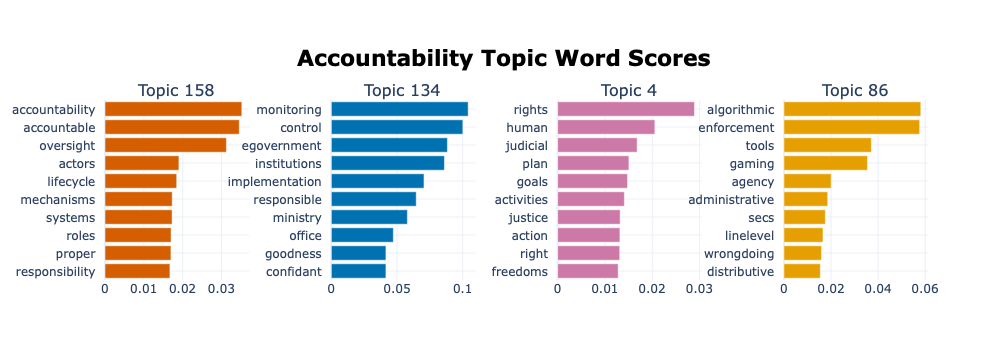

In [33]:
import plotly.io as pio

fig = loaded_model.visualize_barchart(topics = accountability_topics, n_words = 10, title = '<b>Accountability Topic Word Scores</b>')

fig.show()


We can go a step further and look at some of the related ethical concepts to accountability in AI regulation. Below, I am getting the top four topics for 'responsibility', 'transparency', and 'explainability' to visualize them together with the top topics for accountability.

In [36]:
# Extracting top 4 topics for ethical principles
responsibility_topics, similarity = topic_model.find_topics("responsibility", top_n=4)
transparency_topics, similarity = topic_model.find_topics("transparency", top_n=4)
explainability_topics, similarity = topic_model.find_topics("explainability", top_n=4)

# Adding all the top topics together into one list to pass to the barchart later
ethics_principles = accountability_topics + responsibility_topics + transparency_topics + explainability_topics

In the next step, I wanted to create custom labels for each of the principles in order to make the graph more legible. While the code below works fine, I still opted to not use it in the end. We will see during the visualization why that is.

In [79]:
# Function for creating custom labels
def create_custom_label(top_n, list_of_topics, keyterm):   
    custom_labels = {}
    for topic_num in range(top_n):
        custom_labels[list_of_topics[topic_num]] = str(topic_num +1) + '_topic_' + str(keyterm)
    return custom_labels

topic_model.set_topic_labels(create_custom_label(4, accountability_topics, 'accountability'))
topic_model.set_topic_labels(create_custom_label(4, responsibility_topics, 'responsibility'))
topic_model.set_topic_labels(create_custom_label(4, transparency_topics, 'transparency'))
topic_model.set_topic_labels(create_custom_label(4, explainability_topics, 'explainability'))

Let's visualize the four ethical principles we have collected the top topics for. Each row of barcharts corresponds to one of the concepts in the following order:
1. Accountability
2. Responsibility
3. Transparency
4. Explainability

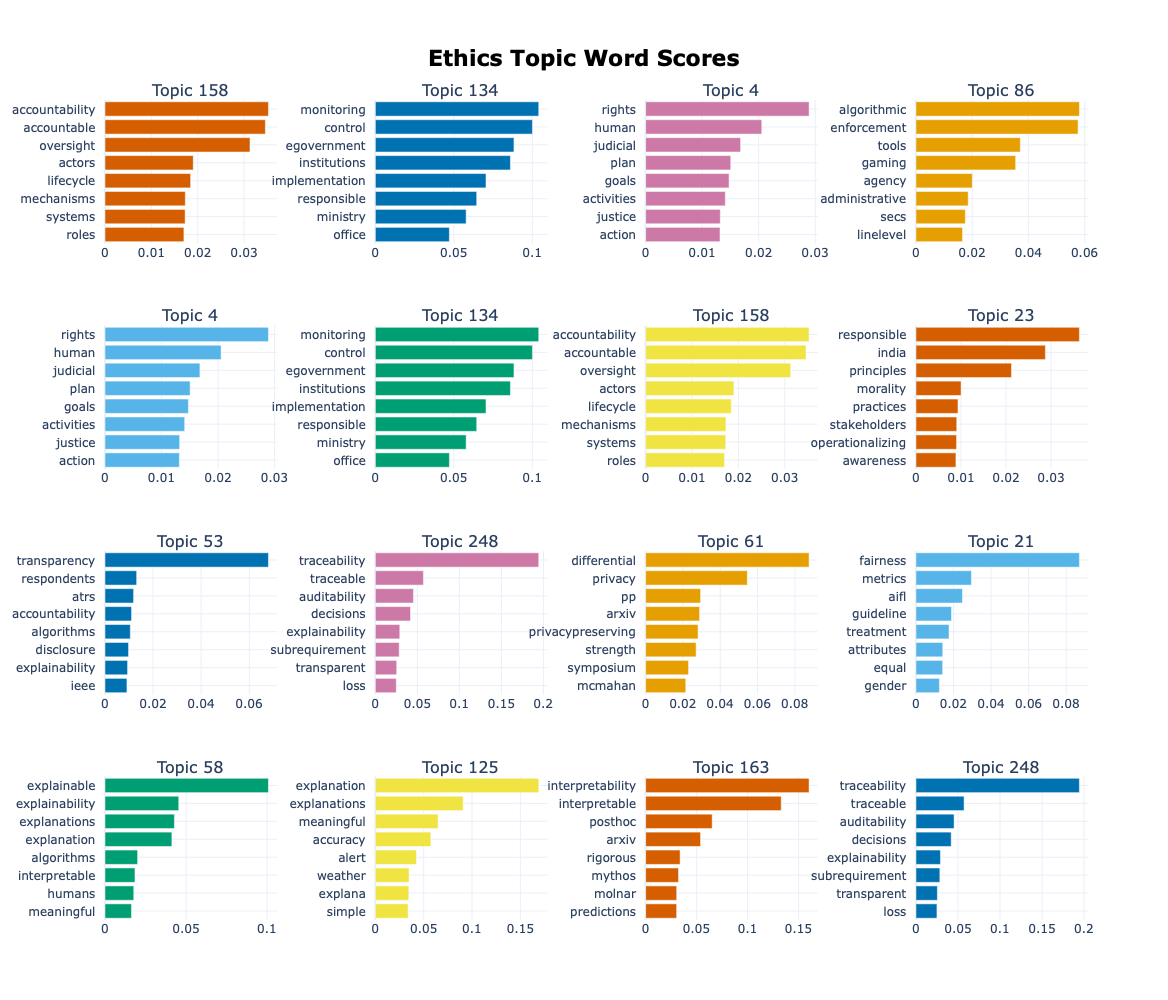

In [78]:
# Visualizing all top 4 topics related to ethical AI principles:
topic_model.visualize_barchart(topics = ethics_principles, n_words = 8, title = '<b> Ethics Topic Word Scores</b>', custom_labels = False)

The barcharts visualize some keyterms associated to the ethical principles. Further, we can see that there is some overlap between the principle's topics. Accountability and responsibility both share 3 of their top topics, namely topic 158, 134, and 4 just in reverse order. This could indicate that accountabilty and responsibility are intertwined concepts in the literature just as the literature review suggests.

### Visualizing the top paragraphs assigned to the accountability topics:

Another useful feature of BERTopic is that the top three documents associated with each topic are saved by the model and can easily be extracted and examined. In the code below, I am saving the model to a Pandas DataFrame. 

Then, the top 3 paragraphs pertaining to the #1 topic of accountability are printed and the topic words highlighted in bold. In this way, we can see the topic of accountability and associated words in a bit more context. 

In [81]:
# Saving the topic model data in a Pandas DataFrame
BERTopic_v1_df = topic_model.get_topic_info()

# Extracting to #1 topic related to accountability from the DataFrame
accountability = BERTopic_v1_df[BERTopic_v1_df['Topic'] == accountability_topics[0]]

# Getting top 3 paragraphs 
rep_docs = accountability['Representative_Docs'].item()

# Getting top representation wordswords 
representation = accountability['Representation'].item()

The function below allows us to us to pass the representative words and top 3 documents of a given topic and print them in a readable format:

In [73]:
from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def display_top_docs(rep_docs, representation):
    counter = 1 # Counting the top documents
    for doc in rep_docs: 
        for word in representation:
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE) #putting all the representative words in bold
                
        make_md(f'**Top document #{counter}**: \n\n*{doc}*\n\n') # Printing the paragraph
        counter += 1

In [74]:
# Displaying top 3 documents for 
display_top_docs(rep_docs, representation)

**Top document #1**: 

*Accountability: People responsible for the different phases of the AI  system **lifecycle** should be identifiable and **accountable** for the  outcomes of the AI **systems** and human **oversight** of AI **systems**  should be enabled. . The principles are entirely voluntary.*



**Top document #2**: 

*In the case of decisions signiﬁcantly affecting rights, there should be an effective system of **oversight**, which makes appropriate use of human judgment. Accountability Those responsible for the different phases of the AI system **lifecycle**  should be identiﬁable and **accountable** for the outcomes of the AI **systems**, and human **oversight** of AI **systems** should be enabled. This principle aims to acknowledge the relevant organisations’ and individuals’ **responsibility** for the outcomes of the AI systems that they design, develop, deploy and operate.*



**Top document #3**: 

*b) To this end, AI **actors** should ensure traceability including in  relation to datasets, processes and decisions made during the AI  system **lifecycle**, to enable analysis of the AI system’s outcomes  and responses to inquiry, appropriate to the context and  consistent with the state of art. c)  AI **actors** should, based on their **roles**, the context, and their  ability to act, apply a systematic risk management approach to  each phase of the AI system **lifecycle** on a continuous basis to  address risks related to AI **systems** including privacy, digital  security, safety and bias. (v)  Accountability - AI actors should be **accountable** for the **proper**  functioning of AI **systems** and for the respect of the above principles  based on their **roles**, the context, and consistent with the state of art.*



### Visualizing the topics' distances

Lastly, it might be interesting to see how the different topics relate and cluster together.

In the case of accountability, we know that the top 4 topics associated with the word are topic 158, 134, 4, and 86. Feel free to experiment with the slide at the bottom of the Intertopic Distance Map to see where the topics are located on the map.

When zooming into topic 158, we can see some interesting topics which are visualized in the same cluster such as topics 53 and 248. Topic 53 pertains to transparency and accountability, whereas topic 248 talks about traceability, auditability and explainability. These concepts are indeed closely related in the academic research on AI regulation and ethics. Additionally, it is interesting to see that both topic 158 and topic 53 are the top topics associated with accounability and transparency respectively show up so closely together.

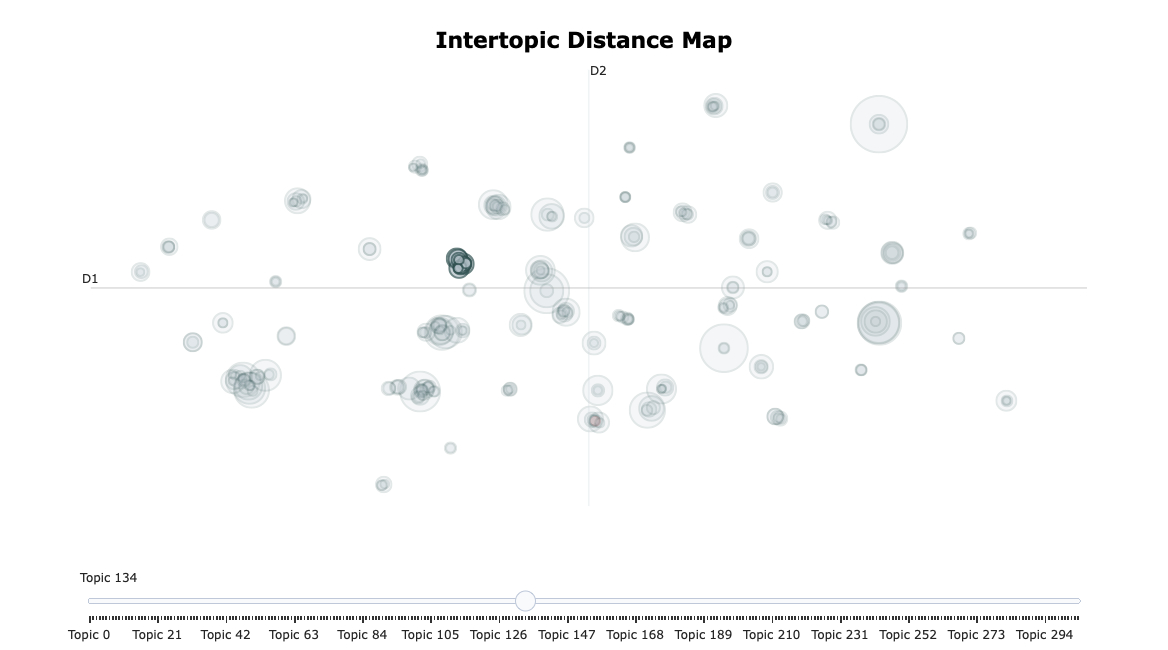

In [82]:
topic_model.visualize_topics()